# Generating Land Surface Temperature from multispectral imagery using Pix2Pix
> * 🔬 Data Science
> * 🥠 Deep Learning and image translation

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export image domain data](#Export-image-domain-data)
* [Methodology](#Methodology)
* [Model training](#Model-training)
  * [Prepare data](#Prepare-data)
  * [Load model architecture](#Load-model-architecture)
  * [Tuning for optimal learning rate](#Tuning-for-optimal-learning-rate)
  * [Fit the model](#Fit-the-model)
  * [Visualize results in validation set](#Visualize-results-in-validation-set)
  * [Save the model](#Save-the-model)
  * [Compute evaluation metrics](#Compute-evaluation-metrics)
* [Model inferencing](#Model-inferencing)
* [Results visualization](#1)
* [Conclusion](#Conclusion)

## Introduction 

Land Surface Temperature (LST) plays an important role in the Earth’s climate system. It represents the process of energy exchange, affecting both water content and vegetation growth rate. Traditionally, LST from Landsat-8 is calculated using a chain of formulas that are complex and demanding of resources. Fortunately, deep learning models provide an efficient way to compute and predict LST. In this study, we propose an approach to predicting LST from Landsat 8 imagery using the [Pix2Pix](https://developers.arcgis.com/python/guide/how-pix2pix-works/) deep learning model. The LST will be computed on a thermal band (band 10) from a single Landsat 8 image. The calculated LST will then be used to train an image translation Pix2Pix model. The model will then be capable of translating Landsat-8 multispectral imagery to LST, allowing the predictions to be used for multitemporal monitoring of LST.

## Necessary imports

In [1]:
import os
from pathlib import Path

from arcgis import GIS
from arcgis.learn import Pix2Pix, prepare_data

 ## Connect to your GIS

In [2]:
gis = GIS('home')

## Export image domain data

A stacked raster of Landsat-8 bands has been created using bands 1-7 and band 10. This mosaic will be used as our `input_raster` for the training data.

<Item title:"landsat_composite" type:Imagery Layer owner:demos_deldev>
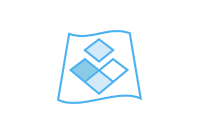

In [3]:
landsat_mosaic = gis.content.get('952468e0942c4b6893006cb267cbf040')
landsat_mosaic

The raster for Land Surface Temperature is generated using the thermal band (band 10). This raster will be used as the `Additional Input Raster` for the training data.

<Item title:"LST_raster" type:Imagery Layer owner:demos_deldev>
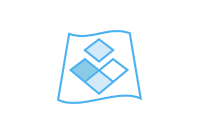

In [4]:
lst_raster = gis.content.get('ad29f8ab93354e77bcb22ba83f9a846a')
lst_raster

## Methodology

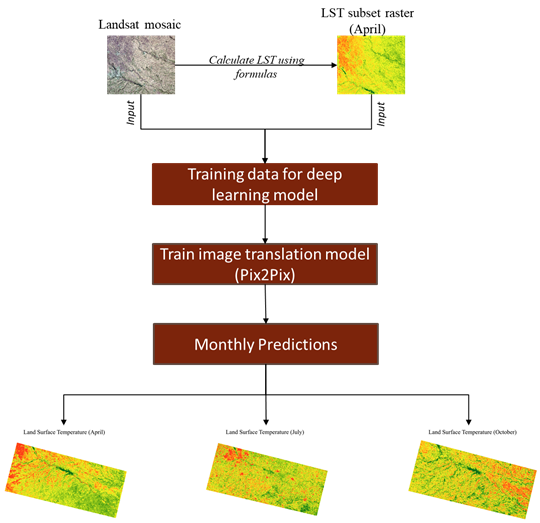

The diagram above encapsulates the overall methodology used in the estimation of the Land Surface Temperature from multispectral imagery using deep learning.

The data will be exported in the “Export_Tiles” metadata format, which is available in the [Export Training Data For Deep Learning tool](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). This tool is available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server). The various inputs required by the tool are described below:

- `Input Raster`: landsat_composite_raster

- `Additional Input Raster`: lst_raster

- `Tile Size X & Tile Size Y`: 256

- `Stride X & Stride Y`: 128

- `Meta Data Format`: 'Export_Tiles' (as we are training a `Pix2Pix` model).

- `Environments`: Set optimum `Cell Size`, `Processing Extent`.

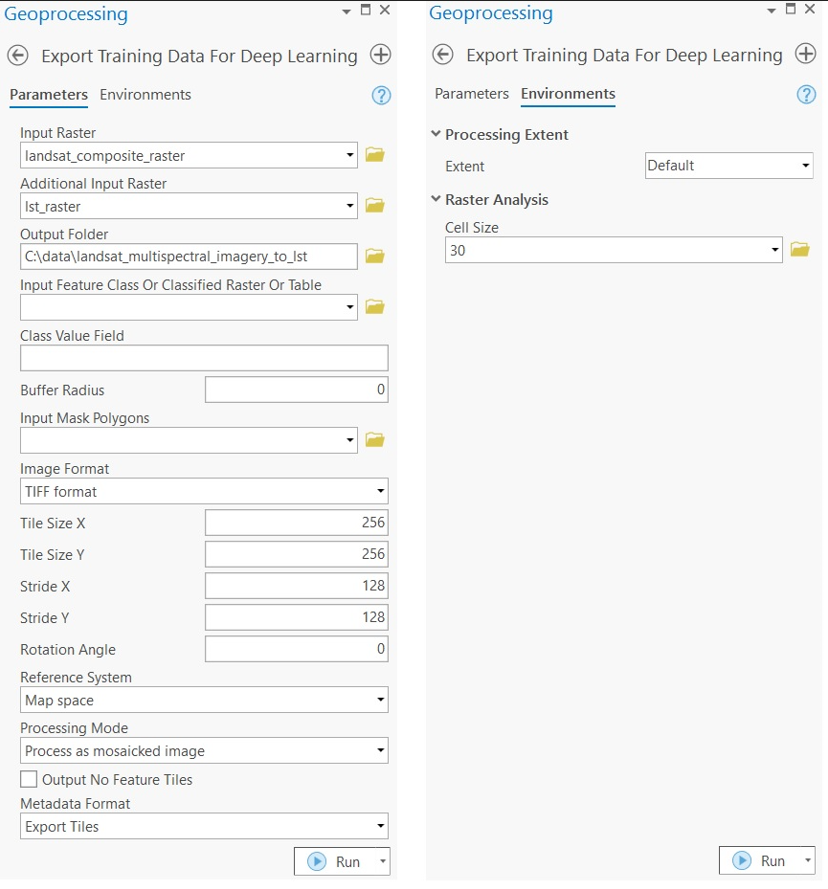

Inside the exported data folder, the 'Images' and 'Images2' folders contain all of the image tiles from the two domains exported from `landsat_composite_raster` and `lst_raster` respectively.

## Model training

Alternatively, we have provided a subset of training data containing a few samples that follow the same directory structure mentioned above and that provides the rasters used for exporting the training dataset. This data can be used to run the experiments.

<Item title:"generating_lst_from_multispectral_imagery_using_pix2pix" type:Image Collection owner:demos_deldev>
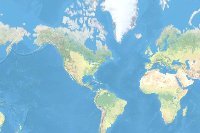

In [5]:
training_data = gis.content.get('11ebeb485c2d44898b32b91b105f8de6')
training_data

In [6]:
filepath = training_data.download(file_name=training_data.name)

In [7]:
#Extract the data from the zipped image collection
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

### Prepare data

In [8]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [9]:
data = prepare_data(output_path, dataset_type="Pix2Pix", batch_size=8)

### Visualize a few samples from your training data

To get a sense of what the training data looks like, the `arcgis.learn.show_batch()` method randomly picks a few training chips and visualizes them. Below, the images displayed on the left are Landsat-8 rasters, and the images on the right are the corresponding LST rasters.

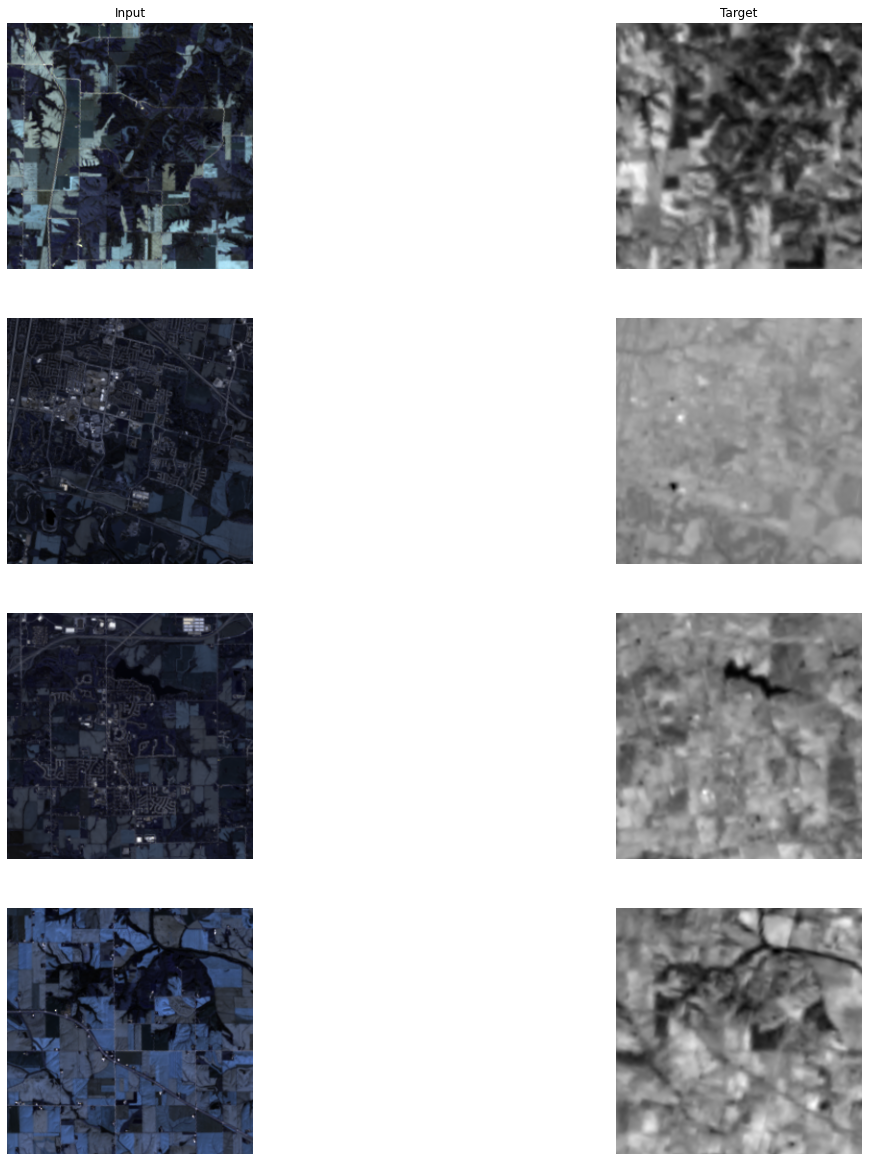

In [10]:
data.show_batch()

### Load model architecture

In [11]:
model = Pix2Pix(data)

### Tuning for optimal learning rate

Learning rate is one of the most important hyperparameters in model training. ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

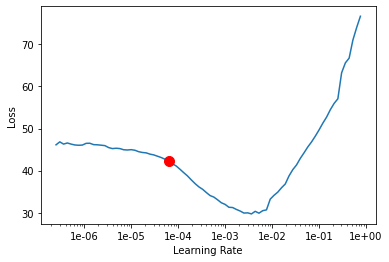

6.309573444801929e-05

In [12]:
lr = model.lr_find()
lr

### Fit the model

Next, the model is trained for 30 epochs with the suggested learning rate.

In [13]:
model.fit(30, lr)

epoch,train_loss,valid_loss,gen_loss,l1_loss,D_loss,time
0,35.566357,30.796040,0.663380,0.349030,0.717529,01:05
1,19.291725,12.093425,0.622104,0.186696,0.742149,01:08
2,11.148993,8.225349,0.592061,0.105569,0.758912,01:11
3,7.698595,6.032180,0.579509,0.071191,0.764611,01:13
4,5.424048,3.987901,0.581081,0.048430,0.762080,01:12
5,3.604111,3.223908,0.593590,0.030105,0.753615,01:13
6,2.858333,2.664019,0.600027,0.022583,0.749187,01:14
7,2.528771,2.296279,0.604608,0.019242,0.746166,01:13
8,2.322142,2.211593,0.607804,0.017143,0.743662,01:13
9,2.194105,2.021927,0.608942,0.015852,0.742633,01:13


Here, with 30 epochs, we can see reasonable results, as both the training and validation losses have gone down considerably, indicating that the model is learning to translate between imagery domains.

### Save the model

Next, we will save the trained model as a 'Deep Learning Package' ('.dlpk' format). The Deep Learning package format is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the save() method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [14]:
model.save("pix2pix_model", publish=True, overwrite=True)

Published DLPK Item Id: a94c729d87774b5e92a25d344e25364f


WindowsPath('C:/Users/shi10484/AppData/Local/Temp/models/pix2pix_model')

### Visualize results in validation set

It is a good practice to see the results of the model viz-a-viz the ground truth. The code below selects random samples and displays the ground truth and model predictions side by side. This enables us to preview the results of the model within the notebook.

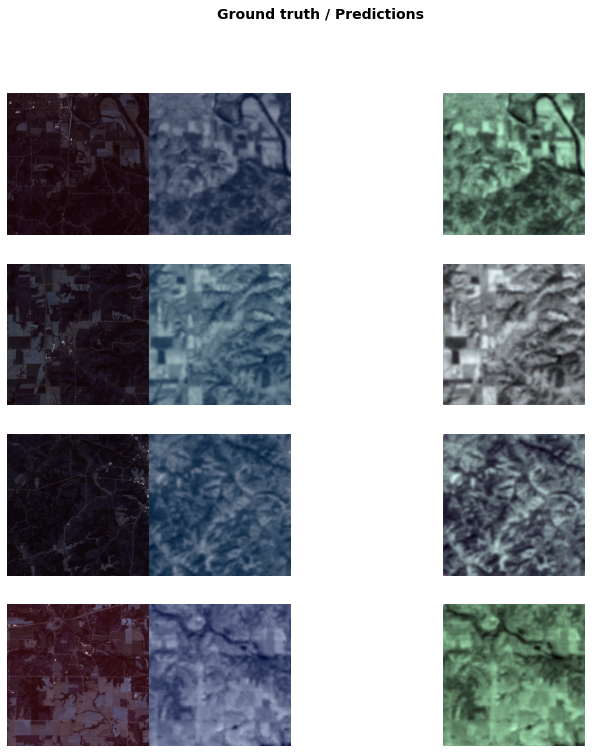

In [15]:
model.show_results(rows=4)

### Compute evaluation metrics

To objectively assess the synthesized image quality obtained from the model generators, we will quantitatively evaluate the results using the `Structural Similarity (SSIM) Index` and the `Peak Signal-to-Noise Ratio (PSNR)`.

The SSIM index measures the structural information similarity between images, with 0 indicating no similarity and 1 indicating complete similarity. The `SSIM value` for the trained model is `0.94`.

The PSNR measures image distortion and noise level between images. A 20 dB or higher PSNR indicates that the image is of good quality. The `PSNR value` for the trained model is `20.9`.

In [16]:
model.compute_metrics()

{'PSNR': '2.0965e+01', 'SSIM': '9.4536e-01'}

## Model inferencing

After training the `Pix2Pix` model and saving the weights for translating images, we can use the [Classify Pixels Using Deep Learning tool](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm), available in both `ArcGIS pro` and `ArcGIS Enterprise`, for inferencing at scale.


In [17]:
model_for_inferencing = gis.content.get('a94c729d87774b5e92a25d344e25364f')
model_for_inferencing

<Item title:"pix2pix_model" type:Deep Learning Package owner:api_data_owner>

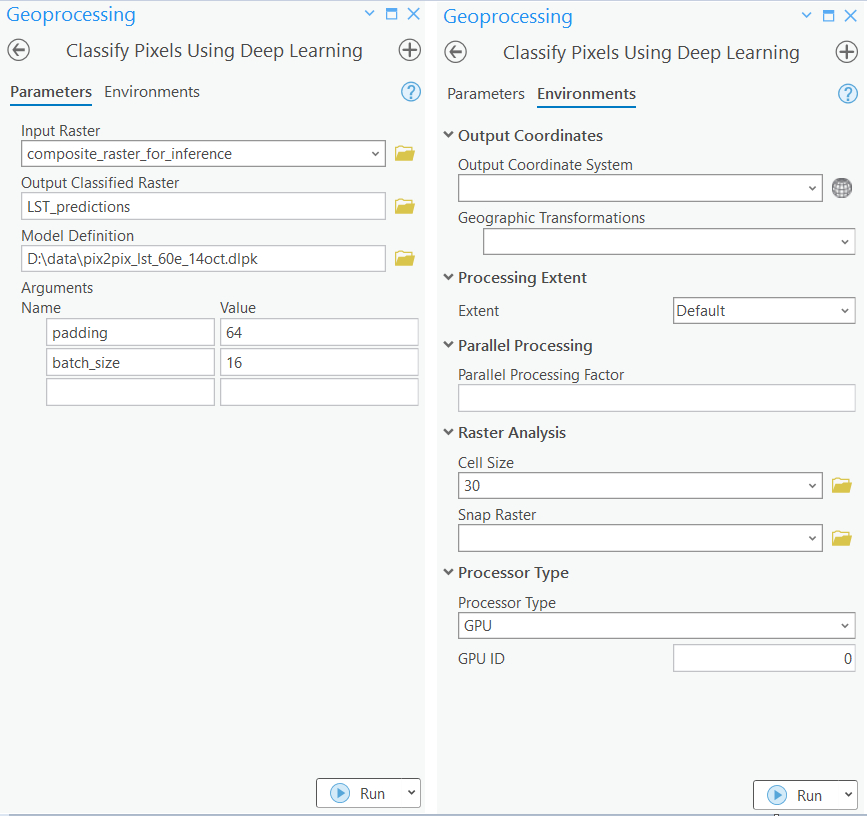

`with arcpy.EnvManager(processorType="GPU"): 
out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("composite_raster_for_inferencing", r"C:\path\to\model.dlpk", "padding 64;batch_size 8;predict_background True; tile_size 224", "PROCESS_AS_MOSAICKED_IMAGE", None); out_classified_raster.save(r"C:\sample\sample.gdb\predicted_lst")`

## Results visualization<a class="anchor" id="1"></a>

Here, the LST for the months of April and July are generated using ArcGIS Pro. The output rasters are then published on our portal for visualization. 

<Item title:"apr_lst_ras" type:Imagery Layer owner:demos_deldev>
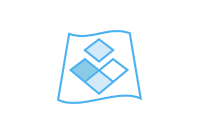

In [18]:
inferenced_results_april = gis.content.get('b52f79a31c994dc0ac30aec41733e564')
inferenced_results_april

In [19]:
from arcgis.raster.functions import colormap, stretch
inf_apr_lyr = inferenced_results_april.layers[0]
stretch_rs_apr = colormap(stretch(inf_apr_lyr, 
                                  stretch_type='PercentClip', 
                                  min=0, 
                                  max=255),
                          colormap_name="Condition Number")

<Item title:"july_lst_ras" type:Imagery Layer owner:demos_deldev>
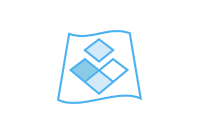

In [20]:
inferenced_results_july = gis.content.get('d02bc8947de64aee9a448a215a70bc94')
inferenced_results_july

In [21]:
inf_july_lyr = inferenced_results_july.layers[0]
stretch_rs_july = colormap(stretch(inf_july_lyr, 
                                  stretch_type='PercentClip', 
                                  min=0, 
                                  max=255),
                          colormap_name="Condition Number")

### Create map widgets
Next, two map widgets are created showing the Landsat 8 mosaic and Inferenced LST raster.

In [22]:
map1 = gis.map('Iowa, USA', 13)
map1.add_layer(stretch_rs_apr)
map2 = gis.map('Iowa, USA', 13)
map2.add_layer(stretch_rs_july)
map3 = gis.map('Iowa, USA', 13)
map3.basemap = 'satellite'
map1.zoom_to_layer(stretch_rs_apr)

### Synchronize web maps

Once created, the maps can be synchronized with each other using the [MapView.sync_navigation](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html#arcgis.widgets.MapView.sync_navigation) functionality. By syncing the two map widgets, we can more easily compare the inferenced results with the DSM. A more detailed description of advanced map widget options can be found [here](https://developers.arcgis.com/python/guide/advanced-map-widget-usage/).

In [23]:
map1.sync_navigation(map2)
map2.sync_navigation(map3)

In [24]:
map1.zoom_to_layer(stretch_rs_apr)

### Set the map layout

In [25]:
from ipywidgets import HBox, VBox, Label, Layout

[Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox) were used to set the layout of map widgets.

In [26]:
hbox_layout = Layout()
hbox_layout.justify_content = 'space-around'

hb1,hb2,hb3=HBox([Label('April')]),\
            HBox([Label('July')]),\
            HBox([Label('RGB Imagery')])
hb1.layout,hb2.layout,hb3.layout=hbox_layout,hbox_layout,hbox_layout

### Results

The predictions are provided as a map for better visualization.

In [27]:
 VBox([hb1,HBox([map1]),hb2,HBox([map2]), hb3,HBox([map3])])

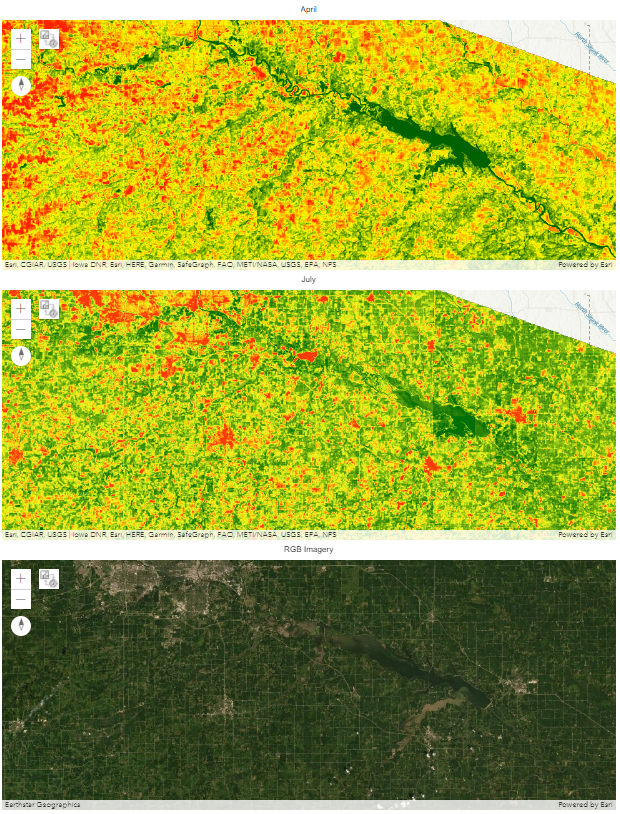

In [28]:
map2.zoom_to_layer(stretch_rs_apr)

In the maps above, the land surface temperature increases from dark green to red. The corn crop is usually sown in late April or early May, therefore, in the month of April, there will be little to no crop. This can be seen in April's prediction, where most of the area is yellow or orange in color, indicating a high land surface temperature. However, in the month of July, the crop is fully grown, resulting in the predictions for most of the area being dark or light green in color.

## Conclusion

In this notebook, we have demonstrated how to use a `Pix2Pix` model using `ArcGIS API for Python` to translate imagery from one domain to another.